In [2]:
import pandas as pd
import numpy as np
import pickle
import keras
from keras.models import Model, Sequential
from keras.applications import resnet50, vgg16
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, KFold
from keras import backend as K
from keras.layers import *
from keras import layers
from keras.callbacks import EarlyStopping, Callback
from keras.regularizers import l1, l2
# from skimage.io import imread
import sklearn
import lightgbm as lgb
import time
K.set_image_data_format('channels_last')

path = '../Data/'

# class_emb = pd.read_csv(path + '/DatasetA_train_20180813/class_wordembeddings.txt', 
#                         index_col = 0, sep = ' ', header = None)
# class_emb.index.name = 'class_name'
# # class_emb_vec = pd.DataFrame(index = class_emb.index)
# class_emb = class_emb.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_to_name = pd.read_csv(path + '/DatasetA_train_20180813/label_list.txt', 
#                                index_col = 'class_name', sep = '\t', header = None, names = ['class_id', 'class_name'])

# attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)

# attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
#                                    index_col = 0, sep = '\t', header = None)
# attributes_per_class.index.name = 'class_id'
# attributes_per_class = attributes_per_class.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_emb_attr = class_id_to_name.copy()
# class_id_emb_attr['emb'] = class_emb
# class_id_emb_attr.reset_index(inplace = True)
# class_id_emb_attr.set_index('class_id', inplace = True)
# class_id_emb_attr['attr'] = attributes_per_class

# with open(path + 'class_id_emb_attr.pickle', 'wb+') as handle:
#     pickle.dump(class_id_emb_attr, handle)
def read_image(imag_path, image_id):
    img = image.load_img(imag_path + image_id)
    img = image.img_to_array(img)
#     img= vgg16.preprocess_input(image.img_to_array(img))
    return img

In [3]:
import keras
keras.__version__

'2.0.8'

In [3]:
# train_data = pd.read_csv(path + '/DatasetA_train_20180813/train.txt', index_col = 'class_id', 
#                          sep = '\t', header = None, names = ['image_id', 'class_id'])
# train_data = train_data.merge(class_id_emb_attr, how = 'left', on = 'class_id')

# imag_path = path + r'/DatasetA_train_20180813/train/'

# train_data['img'] = train_data['image_id'].apply(lambda id: read_image(id))

# train_data.reset_index(inplace = True)
with open(path + 'class_id_emb_attr.pickle', 'rb') as handle:
    class_id_emb_attr = pickle.load(handle)
class_id_emb_attr.reset_index(inplace = True)    
with open(path + 'train_img.pickle', 'rb') as handle:
    train_data = pickle.load(handle)

In [5]:
train_data.head()

,class_id,image_id,class_name,emb,attr,img
0,ZJL1,a6394b0f513290f4651cc46792e5ac86.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[20.0, 33.0, 7.0], [19.0, 32.0, 6.0], [22.0,..."
1,ZJL1,2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[140.0, 45.0, 51.0], [144.0, 47.0, 54.0], [1..."
2,ZJL1,eda9f3bef2bd8da038f6acbc8355fc25.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[81.0, 69.0, 21.0], [86.0, 74.0, 26.0], [85...."
3,ZJL1,7d93ef45972154aae150b4f9980a79c0.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[16.0, 14.0, 15.0], [18.0, 16.0, 17.0], [19...."
4,ZJL1,fb901b4f9a8e396c1d0155bccc5e5671.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[120.0, 124.0, 127.0], [89.0, 93.0, 96.0], [..."


In [49]:
imread(path + '/DatasetA_train_20180813/train/a6394b0f513290f4651cc46792e5ac86.jpeg').shape

(64, 64, 3)

In [56]:
category = train_data['class_id'].unique()
category_dict = dict((category[i], i) for i in range(category.shape[0]))

# vgg_model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = train_data['class_id'].unique().shape[0])


# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)

# input = Input(shape = (2048, ))
# dense = Dense(2048, activation="relu")(input)
# dense = Dropout(0.5)(dense)
# dense = Dense(2048, activation="relu")(input)
# dense = Dense(1024, activation="relu")(input)
# dense = Dense(category.shape[0], activation="softmax")(input)

# vgg_model = Model(input, dense)

# vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

# print (vgg_model.summary())

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)
# train_data['target'] = list(train_image_feature_map)

class DenseNet:
    """
    """
    def __init__(self, cat_max, blocks, weight_decay, kernel_initializer, reduction):
        self.cat_max = cat_max
        self.blocks = blocks
        self.weight_decay = weight_decay
        self.kernel_initializer = kernel_initializer
        self.model = self.small_densenet(classes = self.cat_max, 
                                         blocks = self.blocks, 
                                         weight_decay = self.weight_decay, 
                                         kernel_initializer = self.kernel_initializer,
                                         reduction = reduction)

    def dense_block(self, x, blocks, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A dense block.
        # Arguments
            x: input tensor.
            blocks: integer, the number of building blocks.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        for i in range(blocks):
            x = self.conv_block(x, 32, name=name + '_block' + str(i + 1), 
                weight_decay = weight_decay,
                kernel_initializer = kernel_initializer)
        return x

    def transition_block(self, x, reduction, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A transition block.
        # Arguments
            x: input tensor.
            reduction: float, compression rate at transition layers.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_bn')(x)
        x = layers.Activation('relu', name=name + '_relu')(x)
        x = layers.Conv2D(int(K.int_shape(x)[bn_axis] * reduction), 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_conv')(x)
        x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
        return x

    def conv_block(self, x, growth_rate, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A building block for a dense block.
        # Arguments
            x: input tensor.
            growth_rate: float, growth rate at dense layers.
            name: string, block label.
        # Returns
            Output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x1 = layers.BatchNormalization(axis=bn_axis,
                                    epsilon=1.001e-5,
                                    name=name + '_0_bn')(x)
        x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
        x1 = layers.Conv2D(4 * growth_rate, 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_1_conv')(x1)
        x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_1_bn')(x1)
        x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3,
                        padding='same',
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_2_conv')(x1)
        x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
        return x

    def small_densenet(self, classes = None, 
                       img_input_shape = (64, 64, 3), 
                       blocks = [6, 12, 24, 16], 
                       weight_decay = 1e-4, 
                       kernel_initializer = 'he_normal',
                       reduction = 0.5):
        img_input = Input(shape = (img_input_shape))
        x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False, 
            kernel_initializer = kernel_initializer, 
            kernel_regularizer = l2(weight_decay),
            name='conv1/conv')(x)
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
        x = layers.Activation('relu', name='conv1/relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
        
        x = self.dense_block(x, blocks[0], name='conv2', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.transition_block(x, reduction, name='pool2', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.dense_block(x, blocks[1], name='conv3', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.transition_block(x, reduction, name='pool3', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.dense_block(x, blocks[2], name='conv4', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.transition_block(x, reduction, name='pool4', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        x = self.dense_block(x, blocks[3], name='conv5', weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='bn')(x)
        x = layers.Activation('relu', name='relu')(x)

        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        # x = Lambda(lambda x: x, name = 'densenet_features')(x)
        x = layers.Dense(classes, activation='softmax',
            kernel_initializer = kernel_initializer, 
            kernel_regularizer = l2(weight_decay), 
            name='fc')(x)
        
        model = Model(img_input, x)
        print (model.summary())
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        
        return model
train_data = train_data[:1000]
train_img = extract_array_from_series(train_data['img'])
train_img = vgg16.preprocess_input(train_img)
OneHotEncoder = sklearn.preprocessing.OneHotEncoder()
train_target = train_data['class_id'].apply(lambda id: category_dict[id]).values
train_target = OneHotEncoder.fit_transform(np.reshape(train_target, (-1, 1))).toarray()

In [60]:
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(train_img):
    train_part_img = train_img[train_index]
    validate_part_img = train_img[test_index]
    
    train_part_target = train_target[train_index]
    validate_part_target = train_target[test_index]
    
    print ('Train target nunique: ', np.unique(np.argwhere(train_part_target == 1)[:, 1]).shape[0], 
           'Validate target nuique: ', np.unique(np.argwhere(validate_part_target == 1)[:, 1]).shape[0])
#     model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = category.shape[0])
#     model = resnet50.ResNet50(include_top=True, weights = None, input_shape=(224, 224, 3), classes = category.shape[0])
#     print (model.summary())
#     model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    img_model = DenseNet(blocks = [2, 2, 2, 2], 
                                cat_max = train_target.shape[1],
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5) 
#     print (img_model.summary())
    # img_model = small_vgg(img_input_shape = (64, 64, 3), classes = train_target.shape[1])
#     datagen = keras.preprocessing.image.ImageDataGenerator(
# #             featurewise_center=True,
# #             featurewise_std_normalization=True,
#             rotation_range=20,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             horizontal_flip=True)
#     datagen.fit(train_part_img)
#     h = img_model.model.fit_generator(datagen.flow(train_part_img, train_part_target, batch_size=256), validation_data=(validate_part_img, validate_part_target), 
#                   epochs=100, shuffle=True, verbose = 1, workers=1, use_multiprocessing=False, 
#                   callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=15, verbose=0)])
    h = img_model.model.fit(train_part_img, train_part_target, validation_data=(validate_part_img, validate_part_target), 
                  epochs=100, batch_size = 256, shuffle=True, verbose = 1, 
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=15, verbose=0)])
    break

Train target nunique:  6 Validate target nuique:  6
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_113 (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 70, 70, 3)    0           input_113[0][0]                  
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_________________________________________________________

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 42s 52ms/step - loss: 1.7065 - categorical_accuracy: 0.3562 - val_loss: 1.9188 - val_categorical_accuracy: 0.4100
Epoch 2/100
800/800 [==============================] - 30s 37ms/step - loss: 1.3988 - categorical_accuracy: 0.5288 - val_loss: 2.1152 - val_categorical_accuracy: 0.4600
Epoch 3/100
800/800 [==============================] - 30s 38ms/step - loss: 1.2312 - categorical_accuracy: 0.5862 - val_loss: 2.2976 - val_categorical_accuracy: 0.4700
Epoch 4/100
800/800 [==============================] - 31s 38ms/step - loss: 1.1362 - categorical_accuracy: 0.6212 - val_loss: 1.8414 - val_categorical_accuracy: 0.4450
Epoch 5/100
800/800 [==============================] - 31s 39ms/step - loss: 1.0393 - categorical_accuracy: 0.6700 - val_loss: 1.8027 - val_categorical_accuracy: 0.4450
Epoch 6/100
800/800 [==============================] - 30s 38ms/step - loss: 0.9712 - categorical_accuracy: 0

KeyboardInterrupt: 

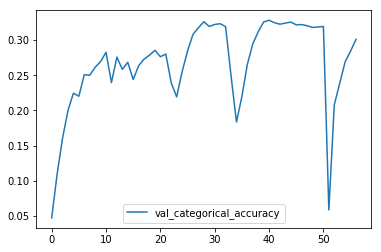

In [57]:
pd.DataFrame(h.history)[['val_categorical_accuracy']].plot()

In [53]:
img_model.model.save(path + '/model_sub/densenet_4_6_8_10_03266.h5')

In [186]:
# np.asarray(list(train_data['img'])).shape
# train_data[train_data['class_id'] == 'ZJL1']
# train_data['class_id'].value_counts().hist()
# train_data.head()
# class_id_emb_attr.iloc[0].name
# resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
img = image.load_img(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = vgg16.preprocess_input(img)
preds = vgg_model.predict(np.expand_dims(img, axis=0))
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])
# imread(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg')
# image.img_to_array(img).shape

Predicted: [('n03598930', 'jigsaw_puzzle', 0.023861792), ('n02095314', 'wire-haired_fox_terrier', 0.022931756), ('n04589890', 'window_screen', 0.021361042)]


In [5]:
def extract_array_from_series(s):
    return np.asarray(list(s))
    
def create_dnn_data(df):
    return [extract_array_from_series(df['attr']), extract_array_from_series(df['emb'])]
            
def lgbm_train(train_part, train_part_label, valide_part, valide_part_label, fold_seed,
        fold = 5, train_weight = None, valide_weight = None, flags = None):
    """
    LGBM Training
    """
    print("-----LGBM training-----")

    d_train = lgb.Dataset(train_part, train_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = train_part[:, -1])
    d_valide = lgb.Dataset(valide_part, valide_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = valide_part[:, -1])
    params = {
            'task': 'train',
            'boosting_type': 'gbdt', #'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            # 'num_leaves':-1,
            'min_sum_hessian_in_leaf':None,
            'max_depth':7,
            'learning_rate':0.005,
            'feature_fraction':0.1,
            'verbose':-1,
            'num_boost_round':3000,
            'drop_rate':None,
            'bagging_fraction':0.6,
            'bagging_freq':5,
            'early_stopping_round':100,
            # 'min_data_in_leaf':100,
            'max_bin': None,
            'scale_pos_weight':None,
        }
    print ("lightgbm params: {0}\n".format(params))

    bst = lgb.train(
                    params ,
                    d_train,
                    verbose_eval = 200,
                    valid_sets = [d_train, d_valide],
                    # feature_name= keras_train.DENSE_FEATURE_LIST,
                    #feval = gini_lgbm
                    #num_boost_round = 1
                    )
    #pred = model_eval(bst, 'l', valide_part)
    #print(pred[:10])
    #print(valide_part_label[:10])
    #print(valide_part[:10, -1])
    # exit(0)
    feature_imp = bst.feature_importance(importance_type = 'gain')
    sort_ind = np.argsort(feature_imp)[::-1]
    print (np.c_[np.array(FEATURE_LIST)[sort_ind], feature_imp[sort_ind]][:10])
    # print (np.array(keras_train.FEATURE_LIST)[np.argsort(feature_imp)])
    # exit(0)
    # cv_result = lgb.cv(params, d_train, nfold=fold) #, feval = gini_lgbm)
    # pd.DataFrame(cv_result).to_csv('cv_result', index = False)
    # exit(0)
    return bst

In [8]:
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)
# img_model_flat = Model(input = img_model.model.input, output = img_model.model.get_layer(name = 'avg_pool').output)
# # train_data['target'] = list(train_y) #
# train_data['target'] = list(img_model_flat.predict(train_img, verbose = 1))
img_model_flat = pd.read_csv(path + '/model_sub/6_12_24_16_03274/sub_2018_09_07_20_58_46.csv')

img_model_flat.set_index('image_id', inplace = True)
train_data['target'] = img_model_flat.apply(lambda s: np.asarray(s.astype(float)), axis = 1).values

In [5]:
img_model_flat.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
image_id,,,,,,,,,,,,,,,,,,,,,
a6394b0f513290f4651cc46792e5ac86.jpeg,0.222450,0.000000,0.000000,0.000000,0.102360,0.410408,0.000000,0.619550,0.469335,0.808152,...,0.638106,1.262975,0.716701,0.649398,0.024636,2.584138,0.299704,0.000000,0.775807,0.657141
2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,0.000000,0.092368,0.000000,0.513933,0.727034,0.205590,0.000000,0.634150,0.386227,1.307551,...,0.289387,1.043166,0.000000,0.270949,0.000000,1.390443,0.291443,0.000000,1.544563,0.258394
eda9f3bef2bd8da038f6acbc8355fc25.jpeg,0.192894,0.106830,0.000000,0.031785,0.642721,0.485429,0.000000,0.463746,0.188616,0.250049,...,0.681179,2.148037,0.335496,0.230386,0.000000,1.919400,0.227866,0.139630,0.000000,0.529273
7d93ef45972154aae150b4f9980a79c0.jpeg,0.518664,0.570357,0.081985,0.000000,0.470126,0.712403,0.132547,0.683170,0.231919,0.490414,...,1.055093,0.289770,1.330755,0.931580,0.007386,2.596373,0.145607,0.000000,0.296896,0.000000
fb901b4f9a8e396c1d0155bccc5e5671.jpeg,0.580390,0.293492,0.007867,0.231948,0.214693,0.486738,0.000000,0.000000,0.000000,0.163543,...,0.000000,0.269853,0.458110,0.080292,0.000000,0.149054,0.000000,0.059787,1.077016,0.858712


In [5]:
train_data.head()

,class_id,image_id,class_name,emb,attr,img,target
0,ZJL1,a6394b0f513290f4651cc46792e5ac86.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[20.0, 33.0, 7.0], [19.0, 32.0, 6.0], [22.0,...","[1.5649712, 0.22537939999999998, 0.0, 0.511434..."
1,ZJL1,2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[140.0, 45.0, 51.0], [144.0, 47.0, 54.0], [1...","[0.95975924, 0.31657952, 0.005624798, 0.542549..."
2,ZJL1,eda9f3bef2bd8da038f6acbc8355fc25.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[81.0, 69.0, 21.0], [86.0, 74.0, 26.0], [85....","[0.73883903, 0.08649281, 0.12541012, 0.1657913..."
3,ZJL1,7d93ef45972154aae150b4f9980a79c0.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[16.0, 14.0, 15.0], [18.0, 16.0, 17.0], [19....","[0.97788334, 0.741634, 0.28850228, 0.12216809,..."
4,ZJL1,fb901b4f9a8e396c1d0155bccc5e5671.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[120.0, 124.0, 127.0], [89.0, 93.0, 96.0], [...","[0.6483536999999999, 0.4635263, 0.4247312, 0.0..."


In [9]:
def find_nearest_class(class_id_emb_attr, model, eval_df, img_feature_map = None):
    if img_feature_map is None:
        img_feature_map = np.reshape(vgg_model.predict(np.asarray(list(eval_df['img'])), verbose = 1), (eval_img.shape[0], -1))
    cand_feature_map = model.predict(create_dnn_data(class_id_emb_attr))
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
    for i in range(img_feature_map.shape[0]):
        img = img_feature_map[i]
        dis = np.linalg.norm(img - cand_feature_map, axis = 1)
        min_ind = np.where(dis == np.amin(dis))[0]
        if len(min_ind) > 1:
            print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
#         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
        nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]]['class_id']
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)

class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
#         self.img_feature_map = self.y_val

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
#             zs_model = Model(inputs = self.model.inputs[:2], outputs = self.model.outpus[0])
            pred_nearest_class_id = find_nearest_class(self.class_id_emb_attr, self.model, self.eval_df, self.y_val)
            true_class_id = self.eval_df['class_id'].values
#             print (pred_nearest_class_id, "\n", true_class_id)
            right_num = np.sum(pred_nearest_class_id == true_class_id)
            score = right_num / true_class_id.shape[0]
            self.scores.append("epoch:{0} {1}".format(epoch + 1, score))
            print("\n Accuracy epoch: %d - score: %.6f \n %d/%d" % (epoch+1, score, right_num, true_class_id.shape[0]))
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

def full_connect_layer(input, hidden_dim):
    full_connect = input
    for hn in hidden_dim:
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
#         full_connect = Dropout(0.2)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer='he_normal', activation = 'relu', kernel_regularizer = l2(1e-4))(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
#             full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
#         full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def create_dnn():
    alpha = 0.03
    attr_input = Input(shape = (30,), name = 'attr')
    word_emb = Input(shape = (300,), name = 'wv')
    imag_classifier = Input(shape = (1024,), name = 'img')

    attr_dense = Dense(256, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(attr_input)
#     attr_dense = Dense(512)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(256)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(300, activation="relu")(attr_dense)
    # attr_dense = Dense(512, activation="relu")(attr_dense)

    attr_word_emb = Concatenate()([word_emb, attr_dense])
    attr_word_emb_dense = full_connect_layer(attr_word_emb, hidden_dim = [int(1024 * 1.5)])
    
#     attr_word_emb_dense = Concatenate()([attr_word_emb_dense, attr_word_emb])
    attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [1024])
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)

    model = Model([attr_input, word_emb], outputs = attr_word_emb_dense) #, vgg_output])
    # model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss='mean_squared_error')
#     model.summary()
    return model

def create_siae():
    alpha = 0.03
    gamma = 0.01
    attr_input = Input(shape = (30,))
    word_emb = Input(shape = (300,))
    imag_classifier = Input(shape = (1024,))

    attr_dense = Dense(32, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(attr_input)

    attr_word_emb = Concatenate()([word_emb, attr_dense])
    
#     attr_word_emb_dense = Concatenate()([attr_word_emb_dense, attr_word_emb])
#     attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [1024])
    
    img_from_attr_w2v = full_connect_layer(attr_word_emb, hidden_dim = [1024, 1024, 1024, 1024])
    attr_w2v_from_img = full_connect_layer(img_from_attr_w2v, hidden_dim = [512, 512, 512, 332])
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)
    
    mse_loss = keras.losses.mean_squared_error(imag_classifier, img_from_attr_w2v) + \
        gamma * keras.losses.mean_squared_error(attr_word_emb, attr_w2v_from_img)
    model = Model([attr_input, word_emb, imag_classifier], outputs = [img_from_attr_w2v, attr_w2v_from_img]) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss=None)
#     model.summary()
    return model

#data.loc[class_id] #data_atten.loc[n]
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0
class_ids = train_data['class_id'].unique() #[:5]

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(class_ids):
    train_part_id = class_ids[train_index]
    validate_part_id = class_ids[test_index]
    
    train_part_df = train_data[train_data['class_id'].isin(train_part_id)]
    validate_part_df = train_data[train_data['class_id'].isin(validate_part_id)]

    train_part_data = create_dnn_data(train_part_df)
    train_part_target = extract_array_from_series(train_part_df['target'])
    
    validate_part_data = create_dnn_data(validate_part_df)
    validate_part_target = extract_array_from_series(validate_part_df['target'])
    
    print('fold: %d th train :-)' % (num_fold))
    print('Train size: {} Valide size: {}'.format(train_part_df.shape[0], validate_part_df.shape[0]))
    print('Train category: {} Valide category: {}'.format(train_part_id.shape[0], validate_part_id.shape[0]))

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, verbose=0),
            AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
                class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(validate_part_id)], eval_df = validate_part_df)
            ]
    
    zs_model = create_dnn()
    if num_fold == 0:
        print (zs_model.summary())
    zs_model.fit(train_part_data, train_part_target,  validation_data = (validate_part_data, validate_part_target),
                  epochs=1, batch_size = 512, shuffle=True, verbose = 2, callbacks=callbacks)
    break
#     model = lgbm_train(train_part_data[0], train_part_target, validate_part_data[0], validate_part_target, num_fold, fold)
    num_fold += 1

fold: 0 th train :-)
Train size: 30579 Valide size: 7642
Train category: 152 Valide category: 38
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
attr (InputLayer)                (None, 30)            0                                            
____________________________________________________________________________________________________
wv (InputLayer)                  (None, 300)           0                                            
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 256)           7680        attr[0][0]                       
____________________________________________________________________________________________________
concatenate_4 (Concatenate)      (None, 556)           0           wv[0][0]                    

k:  size v:  512 batch_size:  512
k:  loss v:  0.6637999 batch_size:  512
k:  batch v:  55 batch_size:  512
k:  size v:  512 batch_size:  512
k:  loss v:  0.6558645 batch_size:  512
k:  batch v:  56 batch_size:  512
k:  size v:  512 batch_size:  512
k:  loss v:  0.6580056 batch_size:  512
k:  batch v:  57 batch_size:  512
k:  size v:  512 batch_size:  512
k:  loss v:  0.65530294 batch_size:  512
k:  batch v:  58 batch_size:  512
k:  size v:  371 batch_size:  371
k:  loss v:  0.6520934 batch_size:  371
k:  batch v:  59 batch_size:  371

 Accuracy epoch: 1 - score: 0.162130 
 1239/7642
2s - loss: 0.7782 - val_loss: 0.8183


In [48]:
def find_nearest_class(class_id_emb_attr, model, eval_df, img_feature_map = None):
    if img_feature_map is None:
        img_feature_map = np.reshape(vgg_model.predict(np.asarray(list(eval_df['img'])), verbose = 1), (eval_img.shape[0], -1))
    cand_feature_map = model.predict(create_dnn_data(class_id_emb_attr))
#     attr_w2v_from_img = model.predict(img_feature_map)
#     cand_feature_map = np.hstack(create_dnn_data(class_id_emb_attr))
#     print (cand_feature_map.shape)
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
    cand_size = class_id_emb_attr.shape[0]
    for i in range(img_feature_map.shape[0]):
        img = img_feature_map[i]
#         img = attr_w2v_from_img[i]
        dis = np.linalg.norm(img - cand_feature_map, axis = 1)
#         img = np.array([img_feature_map[i]] * cand_size)
#         dis = model.predict(create_dnn_data(class_id_emb_attr) + [img])
        min_ind = np.where(dis == np.amin(dis))[0]
        if len(min_ind) > 1:
            print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
#         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
        nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]]['class_id']
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)

class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
#         self.img_feature_map = self.y_val

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            zs_model = Model(inputs = self.model.inputs[:2], outputs = self.model.outputs[0])
            pred_nearest_class_id = find_nearest_class(self.class_id_emb_attr, zs_model, self.eval_df, self.y_val)
            true_class_id = self.eval_df['class_id'].values
#             print (pred_nearest_class_id, "\n", true_class_id)
            right_num = np.sum(pred_nearest_class_id == true_class_id)
            score = right_num / true_class_id.shape[0]
            self.scores.append("epoch:{0} {1}".format(epoch + 1, score))
            print("\n Accuracy epoch: %d - score: %.6f \n %d/%d" % (epoch+1, score, right_num, true_class_id.shape[0]))
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

def full_connect_layer(input, hidden_dim):
    full_connect = input
    for hn in hidden_dim:
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
#         full_connect = Dropout(0.2)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer='he_normal', activation = 'relu', kernel_regularizer = l2(1e-4))(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
#             full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
#         full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def create_siae():
    alpha = 0.03
    gamma = 0
    attr_emb_dim = 256
    attr_input = Input(shape = (30,))
    word_emb = Input(shape = (300,))
    imag_classifier = Input(shape = (1024,))

    attr_dense = Dense(attr_emb_dim, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(attr_input)

    attr_word_emb = Concatenate()([word_emb, attr_input])
    
#     attr_word_emb_dense = Concatenate()([attr_word_emb_dense, attr_word_emb])
#     attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [1024])
    
    img_from_attr_w2v = full_connect_layer(attr_word_emb, hidden_dim = [1024 + 512, 1024 + 256, 1024])
    attr_w2v_from_img = full_connect_layer(img_from_attr_w2v, hidden_dim = [1024 - 256, 1024 - 512, 300 + 30])
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)
    
    imag_classifier_loss = Lambda(lambda x: keras.losses.mean_squared_error(x[0], x[1]))([imag_classifier, img_from_attr_w2v])
    attr_word_emb_loss = Lambda(lambda x: keras.losses.mean_squared_error(x[0], x[1]))([attr_word_emb, attr_w2v_from_img])
    mse_loss = K.mean(imag_classifier_loss + gamma * attr_word_emb_loss)
    model = Model([attr_input, word_emb, imag_classifier], 
                  outputs = [img_from_attr_w2v, attr_w2v_from_img, imag_classifier_loss, attr_word_emb_loss]) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss=None)
#     model.summary()
    return model

def create_isae():
    alpha = 0.03
    gamma = 0
    attr_emb_dim = 256
    attr_input = Input(shape = (30,))
    word_emb = Input(shape = (300,))
    imag_classifier = Input(shape = (1024,))

    attr_dense = Dense(attr_emb_dim, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(attr_input)

    attr_word_emb = Concatenate()([word_emb, attr_input])
    
#     attr_word_emb_dense = Concatenate()([attr_word_emb_dense, attr_word_emb])
#     attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [1024])
    
    attr_w2v_from_img = full_connect_layer(imag_classifier, hidden_dim = [1024 - 256, 1024 - 512, 300 + 30])
    img_from_attr_w2v = full_connect_layer(attr_w2v_from_img, hidden_dim = [1024 - 512, 1024 - 256, 1024])
    
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)
    
    imag_classifier_loss = Lambda(lambda x: keras.losses.mean_squared_error(x[0], x[1]))([imag_classifier, img_from_attr_w2v])
    attr_word_emb_loss = Lambda(lambda x: keras.losses.mean_squared_error(x[0], x[1]))([attr_word_emb, attr_w2v_from_img])
    mse_loss = K.mean(attr_word_emb_loss + gamma * imag_classifier_loss)
    model = Model([attr_input, word_emb, imag_classifier], 
                  outputs = [img_from_attr_w2v, attr_w2v_from_img, imag_classifier_loss, attr_word_emb_loss]) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss=None)
#     model.summary()
    return model

#data.loc[class_id] #data_atten.loc[n]
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0
class_ids = train_data['class_id'].unique() #[:5]

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(class_ids):
    train_part_id = class_ids[train_index]
    validate_part_id = class_ids[test_index]
    
    train_part_df = train_data[train_data['class_id'].isin(train_part_id)]
    validate_part_df = train_data[train_data['class_id'].isin(validate_part_id)]

    train_part_data = create_dnn_data(train_part_df)
    train_part_target = extract_array_from_series(train_part_df['target'])
    
    validate_part_data = create_dnn_data(validate_part_df)
    validate_part_target = extract_array_from_series(validate_part_df['target'])
    
    print('fold: %d th train :-)' % (num_fold))
    print('Train size: {} Valide size: {}'.format(train_part_df.shape[0], validate_part_df.shape[0]))
    print('Train category: {} Valide category: {}'.format(train_part_id.shape[0], validate_part_id.shape[0]))

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, verbose=0),
            AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
                class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(validate_part_id)], eval_df = validate_part_df)
            ]
    
    zs_model = create_siae()
    if num_fold == 0:
        print (zs_model.summary())
    zs_model.fit(train_part_data + [train_part_target],  
                 validation_data = (validate_part_data + [validate_part_target], None),
                  epochs=50, batch_size = 32, shuffle=True, verbose = 1, callbacks=callbacks)
    break
#     model = lgbm_train(train_part_data[0], train_part_target, validate_part_data[0], validate_part_target, num_fold, fold)
    num_fold += 1

fold: 0 th train :-)
Train size: 30611 Valide size: 7610
Train category: 152 Valide category: 38


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:103: UserWarning: Output "dense_179" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_179" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:103: UserWarning: Output "dense_182" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_182" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:103: UserWarning: Output "lambda_49" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "lambda_49" during training.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:103: UserWarning: Output "lambda_50" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "lambda_50" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          (None, 300)          0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
concatenate_34 (Concatenate)    (None, 330)          0           input_102[0][0]                  
                                                                 input_101[0][0]                  
__________________________________________________________________________________________________
batch_normalization_143 (BatchN (None, 330)          1320        concatenate_34[0][0]             
__________

In [44]:
zs_model.save(path + 'zs_model.h5')

In [12]:
test_data = pd.read_csv(path + '/DatasetA_test_20180813/DatasetA_test/image.txt', header = None, names = ['img_id'])
imag_path = path + '/DatasetA_test_20180813/DatasetA_test/test/'
test_data['img'] = test_data['img_id'].apply(lambda id: read_image(imag_path, id))

In [13]:
# def sub(imgs):
img_model = DenseNet(blocks = [6, 12, 24, 16], 
                                cat_max = train_target.shape[1],
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5).model
# img_model = small_densenet(blocks = [6, 12, 24, 16], img_input_shape=(64, 64, 3), classes = train_target.shape[1])
img_model = Model(inputs = img_model.inputs, outputs = img_model.get_layer(name = 'avg_pool').output)
img_model.load_weights(path + '/model_sub/6_12_24_16_03274/model_0_2018_09_07_20_58_46.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
test_img = extract_array_from_series(test_data['img'])
test_img = vgg16.preprocess_input(test_img)
test_img_feature_map = img_model.predict(test_img, verbose = 1)

train_id = train_data['class_id'].unique()
class_id_emb_attr.reset_index(inplace = True)

14633/14633 [==============================] - 106s 7ms/step


In [15]:
zs_partial_model = Model(inputs = zs_model.inputs[:2], outputs = zs_model.outputs[0])
test_class_id_emb_attr = class_id_emb_attr[~class_id_emb_attr['class_id'].isin(train_id)]
pred_nearest_class_id = find_nearest_class(test_class_id_emb_attr, zs_partial_model, test_data, test_img_feature_map)

In [36]:
time_label = time.strftime('_%Y_%m_%d_%H_%M_%S', time.gmtime())
sub_name = path + '/model_sub/sub' + time_label + '.txt'
sub = pd.DataFrame(pred_nearest_class_id, index = test_data['img_id'])
sub.to_csv(sub_name, header = False, sep = '\t')

In [23]:
pred_nearest_class_id

array(['ZJL210', 'ZJL217', 'ZJL218', ..., 'ZJL214', 'ZJL237', 'ZJL215'],
      dtype='<U6')